In [40]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        x = torch.arange(0,1+self.h, self.h)
        t = torch.arange(0,6+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        self.len_bc = len(bc1) + len(bc2)
        self.len_ic = len(ic)
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = torch.sin(math.pi*ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2,y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_bc = self.criterion(y_pred[:self.len_bc],self.y_train[:self.len_bc])
        loss_ic = self.criterion(y_pred[self.len_bc:],self.y_train[self.len_bc:])
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_x_dX = torch.autograd.grad(
        du_dx, self.X,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
        )[0]   # -> columns [u_xx, u_xt]

        du_t_dX = torch.autograd.grad(
        du_dt, self.X,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
        )[0]   # -> columns [u_tx, u_tt]

        # Now extract individual components
        du_dxx = du_x_dX[:, 0]
        du_dtt = du_t_dX[:, 1]
        du_dxt = du_x_dX[:, 1]
        du_dtx = du_t_dX[:, 0]
        # c^2 = 1
        loss_pde = self.criterion(du_dtt, du_dxx)

        loss = loss_pde*1.3 + loss_bc*1.05 + loss_ic*1.1
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(10000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [44]:
# training
net = Net()
net.train()

100 0.1341886669397354
200 0.056824058294296265
300 0.0180521123111248
400 0.015502708964049816
500 0.014450957998633385
600 0.013773050159215927
700 0.013689303770661354
800 0.012797428295016289
900 0.012705225497484207
1000 0.012185227125883102
1100 0.012346341274678707
1200 0.011776918545365334
1300 0.01151833776384592
1400 0.011539170518517494
1500 0.011322694830596447
1600 0.011143088340759277
1700 0.011207184754312038
1800 0.011035118252038956
1900 0.024848580360412598
2000 0.010880723595619202
2100 0.010768810287117958
2200 0.010845438577234745
2300 0.010709008201956749
2400 0.010610852390527725
2500 0.010938822291791439
2600 0.010579735040664673
2700 0.01048008631914854
2800 0.01047716848552227
2900 0.010389032773673534
3000 0.010733019560575485
3100 0.010357643477618694
3200 0.010278933681547642
3300 0.011039835400879383
3400 0.010241501964628696
3500 0.010163753293454647
3600 0.010218356736004353
3700 0.010110092349350452
3800 0.010040031746029854
3900 0.011191065423190594
40

In [45]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=60, bias=True)
    (3): Tanh()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): Tanh()
    (10): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [46]:
h = 0.01
k = 0.01

x = torch.arange(0,1+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [47]:
X

tensor([[0.0000, 0.0000],
        [0.0000, 0.0100],
        [0.0000, 0.0200],
        ...,
        [1.0000, 5.9800],
        [1.0000, 5.9900],
        [1.0000, 6.0000]], device='cuda:0')

In [48]:
X.shape

torch.Size([60701, 2])

In [49]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [50]:
y_pred1.shape

(101, 601)

In [51]:
y_pred1

array([[-0.00275093, -0.00230607, -0.0018677 , ..., -0.03268739,
        -0.03929909, -0.04641076],
       [ 0.02904166,  0.02968765,  0.03030146, ...,  0.00537608,
        -0.00050249, -0.00691827],
       [ 0.06080008,  0.06165265,  0.06242546, ...,  0.04293374,
         0.03776411,  0.0320187 ],
       ...,
       [ 0.05566537,  0.05786069,  0.05982048, ...,  0.04931412,
         0.04787342,  0.04623637],
       [ 0.02226339,  0.02450678,  0.02652872, ...,  0.01863036,
         0.01684371,  0.01485047],
       [-0.01136497, -0.0090831 , -0.00699149, ..., -0.0122275 ,
        -0.01438972, -0.01671096]], dtype=float32)

In [52]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

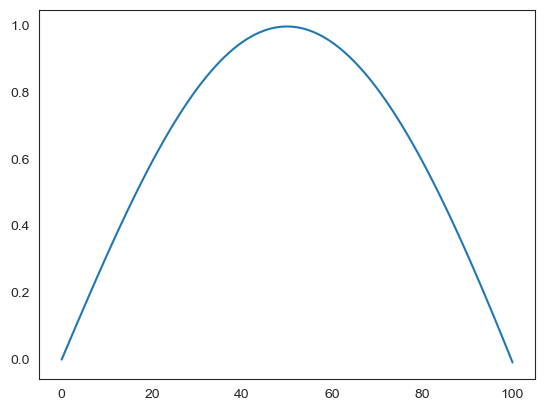

In [53]:
plt.plot(y_pred1[:,0])

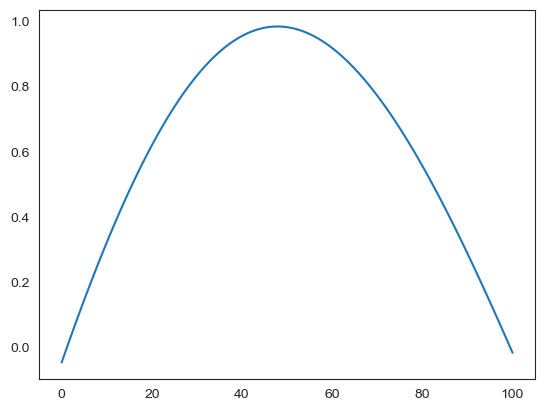

In [54]:
plt.plot(y_pred1[:,-1])

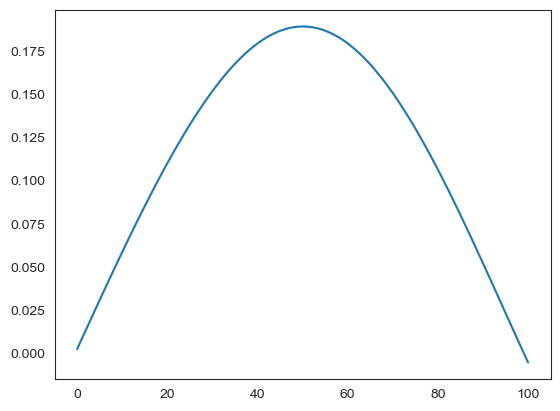

In [55]:
plt.plot(y_pred1[:,50])

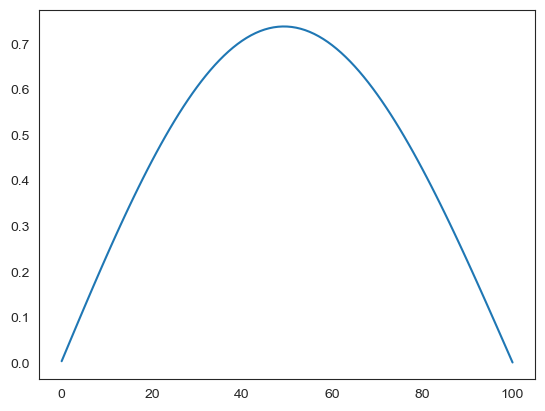

In [56]:
plt.plot(y_pred1[:,30])

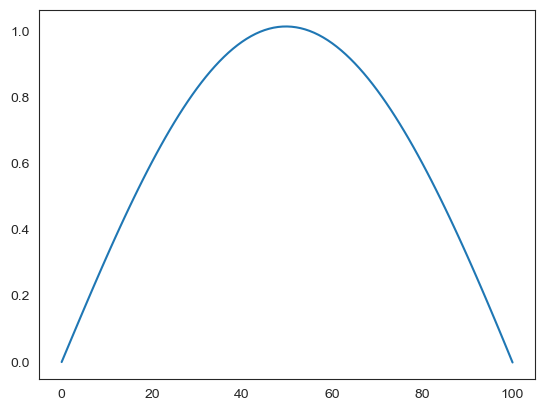

In [57]:
plt.plot(y_pred1[:,5])

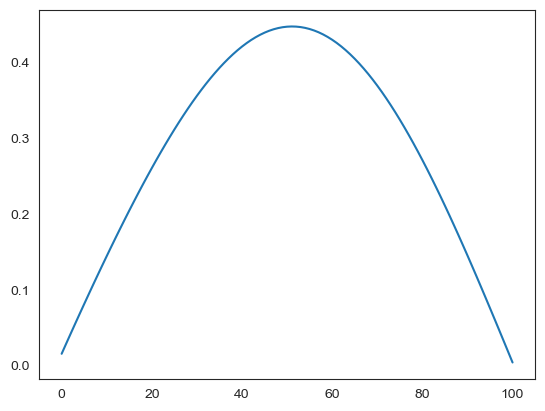

In [58]:
plt.plot(y_pred1[:,-30])

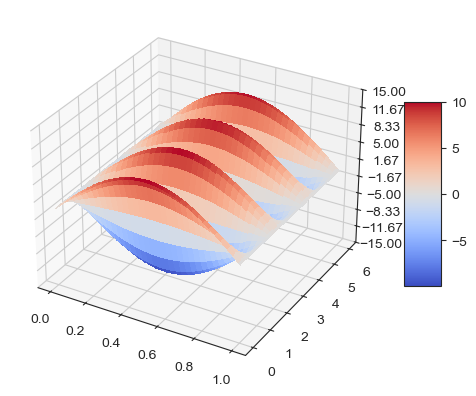

In [59]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-15,15)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [60]:
h = 0.01
k = 0.01

x = torch.arange(0,2+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [61]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [62]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

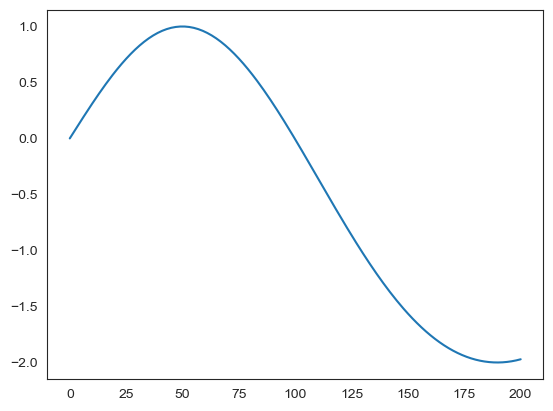

In [63]:
plt.plot(y_pred1[:,0])

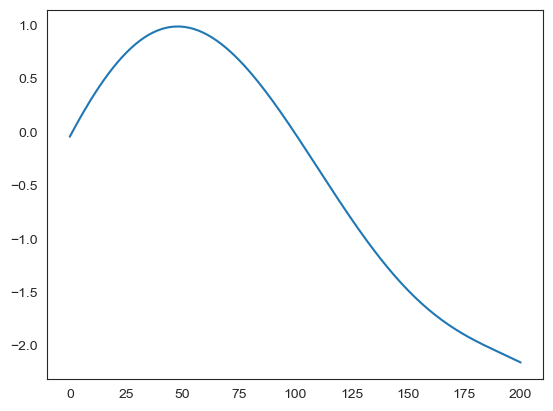

In [64]:
plt.plot(y_pred1[:,-1])

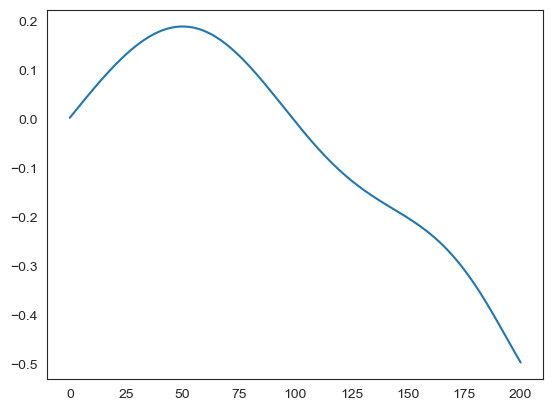

In [65]:
plt.plot(y_pred1[:,50])

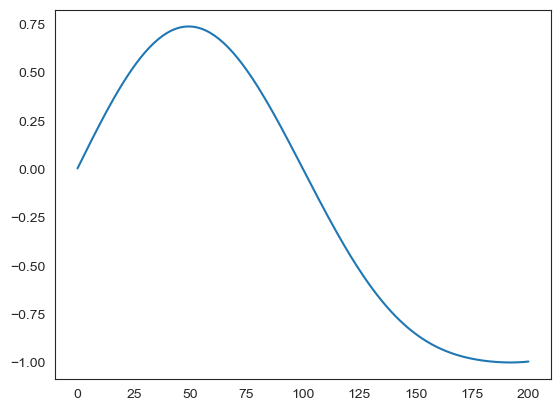

In [66]:
plt.plot(y_pred1[:,30])

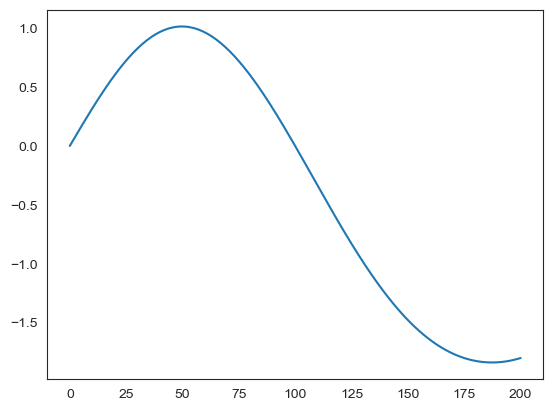

In [67]:
plt.plot(y_pred1[:,5])

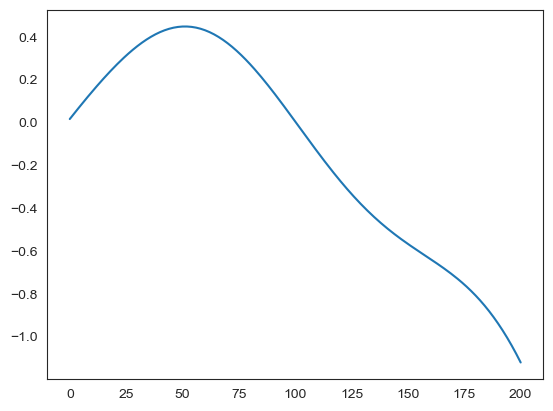

In [68]:
plt.plot(y_pred1[:,-30])

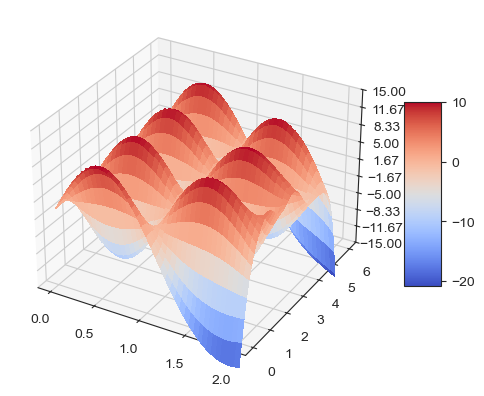

In [69]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-15, 15)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [70]:
h = 0.01
k = 0.01

x = torch.arange(0,3+h, h)
t = torch.arange(0,6+k, k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [71]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred1 = model(X)
    y_pred1 = y_pred1.reshape(len(x),len(t)).cpu().numpy()

In [72]:
sns.set_style("white")
plt.figure(figsize=(5,5), dpi=3000)
sns.heatmap(y_pred1*10, cmap='jet')

<Axes: >

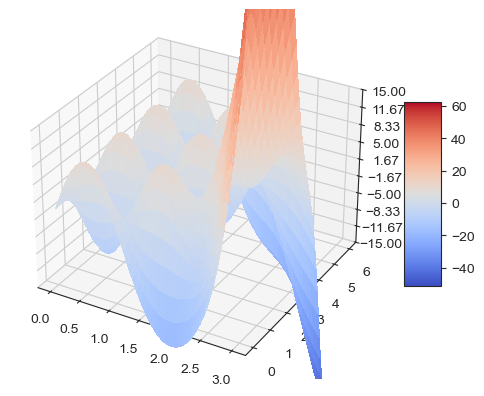

In [73]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

nx, nt = len(x), len(t)          # 101, 601
# Make 2D grids. Use 'ij' so X is (nx,nt) and T is (nx,nt)
X, T = np.meshgrid(x, t, indexing='ij')   # both -> (nx, nt)
# Ensure Z matches (nx, nt)
Z = 10*y_pred1

# Plot the surface.
surf = ax.plot_surface(X,T,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-15, 15)
##ax.set_xlim(-5, 65)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()